In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from ratings.Elo import Elo
from ratings.Rate import Rate
from ratings.helpers import mlog_loss
from ratings.helpers import roc_auc_s

In [1211]:
#import data
fixtures = pd.read_csv('soccer_data_new.csv')
team_info = pd.read_csv('team_info.csv')

In [3]:
#Perform rating
rating = Rate()
rating.calculate_elo(fixtures, K=20, h=70, Sd=True) 

Prepping data...
Starting calculations...
Calculations completed in 7427.563190 seconds================] 100.0% ... Hooray!


In [947]:
fixtures = fixtures.join(rating.ratings_fixtures)

## Set Color Palette

In [370]:
#Torneo color palette
"""
galaxy = [54, 62, 79, 1]
ocean = [14, 113, 163, 1]
glacier = [82, 194, 184, 1]
orangepop = [241, 91, 36, 1]
cloud = [66, 186, 225, 1]
"""
galaxy_rgb = (54,62,79)
ocean_rgb = (14,113,163)
glacier_rgb = (82,194,184)
orangepop_rgb = (241,91,36)
cloud_rgb = (66,186,225)

galaxy = '#363E4F'
galaxy_light = '#5d6b89'
ocean = '#0e71a3'
ocean_light = '#8ad1f5'
glacier = '#52c2b8'
glacier_light = '#a1ded9'
orangepop = '#f15b24'
orangepop_light = '#f6936f'
cloud = '#42bae1'
cloud_light = '#e9f7fc'

## Evaluate Model

### Confusion Matrix

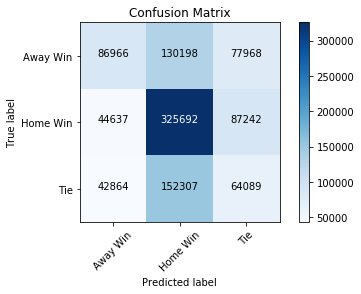

array([[ 86966, 130198,  77968],
       [ 44637, 325692,  87242],
       [ 42864, 152307,  64089]], dtype=int64)

In [5]:
rating.get_confusion_matrix()

### Classification Report

In [6]:
print(rating.get_classification_report())

             precision    recall  f1-score   support

   Away Win       0.50      0.29      0.37    295132
   Home Win       0.54      0.71      0.61    457571
        Tie       0.28      0.25      0.26    259260

avg / total       0.46      0.47      0.45   1011963



### Log Loss

In [7]:
rating.get_log_loss()

(0.44288099909719758, 0.46345651452827141)

### ROC AUC

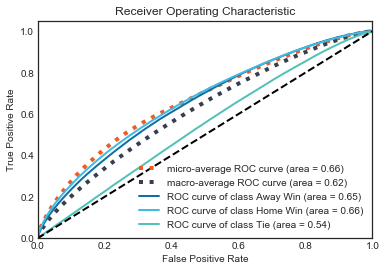

In [220]:
from itertools import cycle

roc_auc, fpr, tpr = roc_auc_s(rating.true, rating.pred)
tie_target_names = ['Away Win', 'Home Win', 'Tie']

def graph_roc_auc(roc_auc, fpr, tpr, n_classes):
    """
    Graphs ROC curves
    """
    if n_classes == 3:
        target_names = tie_target_names
        lw = 2
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]),
                 color=orangepop, linestyle=':', linewidth=4)
        
        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color=galaxy, linestyle=':', linewidth=4)
        
        colors = cycle([ocean, cloud, glacier])
        for color, class_name in zip(colors, target_names):
            plt.plot(fpr[class_name], tpr[class_name], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(class_name, roc_auc[class_name]))  
    else:
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc), color='aqua', linestyle=':', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

graph_roc_auc(roc_auc, fpr, tpr, 3)

## Analysis

### Rating difference vs. likelihood of winning

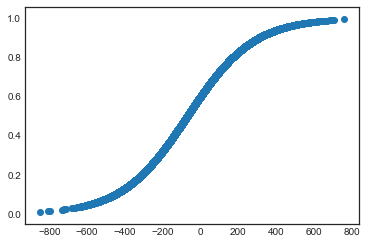

In [9]:
p = fixtures['localteam_p'].values
r_diff = fixtures['localteam_r'].values - fixtures['visitorteam_r'].values
sns.set_style('white')
plt.scatter(r_diff, p)

### Biggest Upsets for Major Leagues

In [949]:
fixtures['local_r_diff'] = np.abs(fixtures['localteam_r'] - fixtures['localteam_post_r'])
fixtures['visitor_r_diff'] = np.abs(fixtures['visitorteam_r'] - fixtures['visitorteam_post_r'])

In [1142]:
major_leagues = [2, 8, 82, 301, 384, 564]
#743
columns = ['starting_datetime', 'league_name', 'localteam_name', 'localteam_score', 'visitorteam_score', 'visitorteam_name', \
           'localteam_p', 'local_r_diff']
ml_fixtures = fixtures[(fixtures['league_id'].isin(major_leagues)) & (pd.to_datetime(fixtures['starting_datetime']) > datetime.date(2017, 1, 1))]
ml_fixtures_ten = ml_fixtures.sort_values('local_r_diff', ascending=False)[columns].head(10)

In [1125]:
ml_fixtures_ten['localteam_p'] = pd.Series(["{0:.2f}%".format(val * 100) for val in ml_fixtures_ten['localteam_p']], index = ml_fixtures_ten.index)
ml_fixtures_ten['local_r_diff'] = np.round(ml_fixtures_ten['local_r_diff'],2)

In [1126]:
ml_fixtures_ten = ml_fixtures_ten.rename(columns={
    'starting_datetime':'Date and Time',
    'league_name':'League', 
    'localteam_name':'Local Team', 
    'localteam_score':'Local Score',
    'visitorteam_score':'Visitor Score', 
    'visitorteam_name':'Visitor Team', 
    'localteam_p':'Local Win Prob.',
    'local_r_diff': 'Rating Change'
})

In [1127]:
import plotly.figure_factory as ff

colorscale = [[0, orangepop],[.5, '#ffffff'],[1, '#ffffff']]

table = ff.create_table(ml_fixtures_ten, colorscale=colorscale)
py.iplot(table, filename='Ten Biggest Upsets in 2017 and 2018')

In [292]:
team_current_rating = rating.ratings_teams
team_current_rating = team_current_rating.reset_index()

In [300]:
PAOK_int_cnt = len(fixtures[((fixtures['localteam_name']=='PAOK') | (fixtures['visitorteam_name']=='PAOK')) & (fixtures['league_country']!='Greece')])
Benfica_int_cnt = len(fixtures[((fixtures['localteam_name']=='Benfica') | (fixtures['visitorteam_name']=='Benfica')) & (fixtures['league_country']!='Portugal')])
print('PAOK has played in %d international matches while Benfica has played in %d international matches'% (PAOK_int_cnt, Benfica_int_cnt))

PAOK has played in 115 international matches while Benfica has played in 184 international matches


In [26]:
import datetime
fixtures_worldcup = fixtures[(fixtures['league_name'] == 'World Cup') & (pd.to_datetime(fixtures['starting_datetime']) > datetime.date(2018, 1, 1))]
fixtures_worldcup.sort_values('local_r_diff', ascending=False).head(10)

,fixture_id,localteam_id,localteam_name,visitorteam_id,visitorteam_name,localteam_score,visitorteam_score,home_team,starting_datetime,league_id,...,visitorteam_outcome,result_order,localteam_r,visitorteam_r,localteam_p,visitorteam_p,localteam_post_r,visitorteam_post_r,local_r_diff,visitor_r_diff
1007026,8636042,18576.0,Mexico,18564,Sweden,0,3,no_home,2018-06-27 14:00:00,732.0,...,1.0,2018-06-27 14:00:00,1751.509114,1646.414984,0.732613,0.267387,1725.697762,1672.226335,25.811351,-25.811351
1007033,8636039,18730.0,Australia,18775,Peru,0,2,no_home,2018-06-26 14:00:00,732.0,...,1.0,2018-06-26 14:00:00,1683.909350,1711.536071,0.560679,0.439321,1667.513768,1727.931653,16.395582,-16.395582
1006790,8636040,18737.0,Nigeria,18644,Argentina,1,2,no_home,2018-06-26 18:00:00,732.0,...,1.0,2018-06-26 18:00:00,1635.236546,1475.849127,0.789258,0.210742,1619.451381,1491.634292,15.785165,-15.785165
48971,8636033,18699.0,Poland,18720,Colombia,0,3,no_home,2018-06-24 18:00:00,732.0,...,1.0,2018-06-24 18:00:00,1626.972373,1737.266020,0.442271,0.557729,1611.390320,1752.848073,15.582053,-15.582053
38861,10344350,18704.0,Brazil,18743,Belgium,1,2,no_home,2018-07-06 18:00:00,732.0,...,1.0,2018-07-06 18:00:00,1927.365871,1784.590734,0.772913,0.227087,1911.907615,1800.048990,15.458256,-15.458256
39648,10346329,18564.0,Sweden,18645,England,0,2,no_home,2018-07-07 14:00:00,732.0,...,1.0,2018-07-07 14:00:00,1681.182561,1743.198410,0.511488,0.488512,1666.225450,1758.155520,14.957110,-14.957110
48893,8636016,18720.0,Colombia,18597,Japan,1,2,no_home,2018-06-19 12:00:00,732.0,...,1.0,2018-06-19 12:00:00,1751.674283,1657.248317,0.720413,0.279587,1737.266020,1671.656580,14.408263,-14.408263
1003228,8636008,18775.0,Peru,18583,Denmark,0,1,no_home,2018-06-16 16:00:00,732.0,...,1.0,2018-06-16 16:00:00,1731.638427,1643.326738,0.713269,0.286731,1717.373042,1657.592123,14.265385,-14.265385
38724,10342083,15251.0,Uruguay,18647,France,0,2,no_home,2018-07-06 14:00:00,732.0,...,1.0,2018-07-06 14:00:00,1720.264245,1806.894059,0.476086,0.523914,1706.342374,1820.815930,13.921871,-13.921871
1007037,8636011,18660.0,Germany,18576,Mexico,0,1,no_home,2018-06-17 15:00:00,732.0,...,1.0,2018-06-17 15:00:00,1790.881080,1729.381516,0.680696,0.319304,1777.267160,1742.995437,13.613921,-13.613921


### Distribution of Team Ratings

In [374]:
team_info_noname = team_info.set_index('team_id').drop('team_name', axis=1)
team_ratings = rating.ratings_teams.join(team_info_noname)

In [376]:
hist_data = []
rug_text = []
countries = ['Argentina', 'Portugal', 'Brazil', 'France', 'Belgium', 'Germany', 'England', 'Spain', 'Italy']

for country in countries:
    hist_data.append(team_ratings[team_ratings['team_country'] == country]['rating'])
    rug_text.append(team_ratings[team_ratings['team_country'] == country]['team_name'])

group_labels = countries
colors = [orangepop, galaxy, glacier, ocean, cloud, galaxy_light, orangepop_light, glacier_light, ocean_light]

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors, rug_text=rug_text)

# Add title
fig['layout'].update(title='Team Rating Distributions by Team Country', yaxis = dict(showgrid=False))

# Plot!
py.iplot(fig, filename='Team Rating Distributions by Team Country')

### Graphing Ratings by Team in Plot.ly

In [1192]:
team_info_reset = team_info.reset_index()

In [1191]:
#add some additional info from the fixtures table
team_fixture_r = rating.ratings_teams_fixtures
team_fixture_r = team_fixture_r.set_index('id')
team_fixture_r = team_fixture_r.join(fixtures[['localteam_name', 'visitorteam_name', 'localteam_score', 'visitorteam_score', 'world_region', 'league_name']])
team_fixture_r = team_fixture_r.join(team_info_reset[['team_country']], on='team_id', how='left')                       

In [1214]:
#Top teams order
#plot top 50 teams
order = rating.ratings_teams.index.values[np.isnan(rating.ratings_teams.index.values) == False]
order = order[:50]
team_fixture_r = team_fixture_r[team_fixture_r.team_id.isin(order)]
team_fixture_r = team_fixture_r[(pd.isnull(team_fixture_r.team_id) == False) & \
                                (pd.isnull(team_fixture_r.localteam_name) == False) & \
                                (pd.isnull(team_fixture_r.visitorteam_name) == False)]
team_fixture_r.team_id = team_fixture_r.team_id.astype("category")
team_fixture_r.team_id.cat.set_categories(order, inplace=True)
team_fixture_r.sort_values(['team_id', 'order'], inplace=True)
teams = team_fixture_r['team_id'].unique()

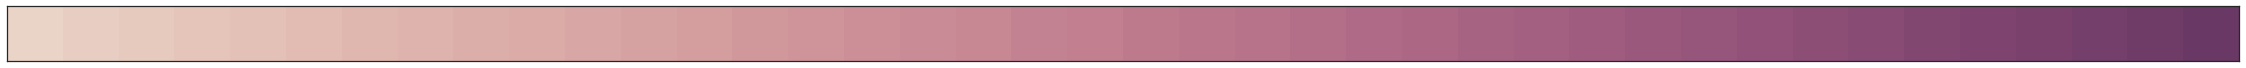

In [1194]:
### Using seaborn to create color palette

"""
import colorlover as cl
from IPython.display import HTML

colors = [(255,69,0), (25,25,112)]
team_colors = cl.interp(colors, len(teams))
HTML(cl.to_html(team_colors))
"""
#sns.choose_cubehelix_palette()
colors_10 = sns.cubehelix_palette(n_colors=10, reverse=True)
colors_rest = sns.cubehelix_palette(n_colors=len(teams)-10, start=0.1, rot=0.4, dark=0.3)
sns.palplot(colors_rest)

colors = colors_10 + colors_rest

team_colors = []

for color in colors:
    values = []
    for value in color:
        value *= 255
        values.append(value)
    values_text = ', '.join(str(x) for x in values)
    values_rgb_str = 'rgb('+ values_text + ')'
    team_colors.append(values_rgb_str)

In [1223]:
#data
data = []
count = 0

for team in teams:
    top = teams[:5]
    if team in top:
        visible = True
    else:
        visible = False
    team_data = team_fixture_r[team_fixture_r['team_id'] == team]
    team_country = team_info[team_info['team_id'] == team]['iso'].values[0]
    team_name = team_data[team_data['team_id'] == team]['team_name'].unique()[0]
    name =  team_name + ' (' + team_country + ')'
    hovertext_local = team_data['localteam_name'] + ' ' + team_data['localteam_score'].map(str)
    hovertext_visitor =  team_data['visitorteam_score'].map(str) + ' ' + team_data['visitorteam_name']
    hovertext = team_data['league_name'] + ': ' + hovertext_local.str.cat(hovertext_visitor.astype(str), sep=' vs. ')
    team_trace = go.Scatter(
        x = team_data.order,
        y = team_data.team_post_r,
        hovertext = hovertext,
        line = {'color': team_colors[count]},
        name = name,
        visible = visible,
        opacity = 0.8)
    count += 1
    data.append(team_trace)

In [1224]:
#filters
team_buttons = []
topteams_buttons = []

"""
#filter for teams
clear = teams == teams
team_buttons.append(dict(label = 'All',
                    method = 'update',
                    args = [{'visible': clear},
                            {'title': 'Top 50 Soccer Teams in the World'}]))

for team in teams:
    team_visibility = teams == team
    team_dict = dict(label = team,
                     method = 'update',
                     args = [{'visible': team_visibility},
                             {'title': team}])
    team_buttons.append(team_dict)
"""

#filter for top teams
top = [5, 10, 25, 50]
for count in top:
    top = teams[:count]
    team_visibility = np.where(np.isin(teams, top), True, False)
    team_dict = dict(label = 'Top {0}'.format(count),
                     method = 'update',
                     args = [{'visible': team_visibility},
                             {'title': 'Top {0} Soccer Teams in the World'.format(count)}])
    topteams_buttons.append(team_dict)


updatemenus = list ([
    dict(active=0,
         showactive = True,
         xanchor = 'left',
         yanchor = 'top', 
         x = -0.05,
         y = 1.3,
         type='buttons',
         direction='right',
         buttons = topteams_buttons)
])

In [1225]:
layout = dict(
    title='Top 5 Soccer Teams in the World',
    hovermode = 'closest',
    xaxis = dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis = dict(
        showgrid=False
    ),
    updatemenus=updatemenus
)

fig = dict(data = data, layout=layout)
py.iplot(fig, filename='soccer_elo_all_50')

## Ratings Deviation

In [1110]:
team_fixture_all = rating.ratings_teams_fixtures
team_fixture_all = team_fixture_all.set_index('id')
team_fixture_all = team_fixture_all.join(fixtures[['localteam_name', 'visitorteam_name', 'localteam_score', 'visitorteam_score', 'world_region', 'league_name', 'league_id']], how='inner')

In [1111]:
team_fixture_all['r_diff'] = np.abs(team_fixture_all['team_r'] - team_fixture_all['team_post_r'])

### Define Volatility

In [1112]:
def volatility(arr):
    
    arr = np.maximum(np.minimum(arr, 1 - 10**-15), 10**-15)
    #log_difference = np.log(arr)
    result = np.std(arr)
    
    return result

### Filter matches down to major leagues

In [1245]:
#For major leagues
fixture_major = team_fixture_all[team_fixture_all['league_id'].isin(major_leagues)]
team_id_major = fixture_major['team_id'].unique()
team_fixture_major = team_fixture_all[(team_fixture_all['team_id'].isin(team_id_major)) & (team_fixture_all['team_id'] != 16951)]

count_fixtures = team_fixture_major.groupby('team_id')['team_id'].count().reset_index(name='count')
count_fixtures = count_fixtures[count_fixtures['count'] > 300]

#filter out teams that have less than 300 fixtures
team_fixture_major = team_fixture_major[team_fixture_major['team_id'] \
                                    .isin(count_fixtures['team_id'])] \
                                    .sort_values(['team_id', 'order'])

In [1246]:
#calculate pct change in ratings
team_fixture_major['rating_change'] = team_fixture_major.groupby('team_id')['team_r'].pct_change()
team_fixture_major['rating_change'] = team_fixture_major['rating_change'].fillna(0)

In [1247]:
deviation_major = team_fixture_major.groupby('team_id')['rating_change'].apply(volatility) \
                .reset_index(name='volatility') 
dev_major_five = deviation_major.sort_values(['team_id', 'volatility'], ascending=False).head()['team_id'].values

### Filter matches down to teams who have played a certain number of matches

In [1248]:
#For all leagues
#filter out teams that have less than 350 fixtures
count_fixtures = team_fixture_all.groupby('team_id')['team_id'].count().reset_index(name='count')
count_fixtures = count_fixtures[count_fixtures['count'] > 300]

team_fixture_condensed = team_fixture_all[team_fixture_all['team_id'] \
                                    .isin(count_fixtures['team_id'])] \
                                    .sort_values(['team_id', 'order'])

In [1249]:
#calculate pct change in ratings
team_fixture_condensed['rating_change'] = team_fixture_condensed.groupby('team_id')['team_r'].pct_change()
team_fixture_condensed['rating_change'] = team_fixture_condensed['rating_change'].fillna(0)

In [1250]:
deviation_cond = team_fixture_condensed.groupby('team_id')['rating_change'].apply(volatility) \
                .reset_index(name='volatility') 
dev_cond_five = deviation_cond.sort_values(['team_id', 'volatility'], ascending=False).head()['team_id'].values

### Plot results

In [1251]:
dev_all = np.append(dev_major_five, dev_cond_five)

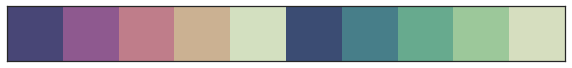

In [1252]:
colors_major = sns.cubehelix_palette(n_colors=5, start=-0.9, rot=1, dark=0.3, reverse=True)
colors_cond = sns.cubehelix_palette(n_colors=5, start=.5, rot=-.75, dark=0.3, reverse=True)
colors = colors_major + colors_cond
sns.palplot(colors)

team_colors = []

for color in colors:
    values = []
    for value in color:
        value *= 255
        values.append(value)
    values_text = ', '.join(str(x) for x in values)
    values_rgb_str = 'rgb('+ values_text + ')'
    team_colors.append(values_rgb_str)

In [1256]:
#filters
dev_grp_buttons = []

#filter for major leagues
team_visibility = [True, True, True, True, True, False, False, False, False, False]
team_dict = dict(label = 'Major Leagues',
                 method = 'update',
                 args = [{'visible': team_visibility},
                         {'title': 'Most Inconsistent Teams - Major European Leagues'}])
dev_grp_buttons.append(team_dict)

team_visibility = [False, False, False, False, False, True, True, True, True, True]
team_dict = dict(label = 'All Leagues',
                 method = 'update',
                 args = [{'visible': team_visibility},
                         {'title': 'Most Inconsistent Teams - All Leagues'}])
dev_grp_buttons.append(team_dict)


updatemenus = list ([
    dict(active=0,
         showactive = True,
         xanchor = 'left',
         yanchor = 'top', 
         x = -0.05,
         y = 1.3,
         type='buttons',
         direction='right',
         buttons = dev_grp_buttons)
])

In [1257]:
data = []
count = 0

for team in dev_all:
    if count < 5:
        visible = True
    else:
        visible = False
    team_data = team_fixture_all[team_fixture_all['team_id'] == team].sort_values('order')
    hovertext_local = team_data['localteam_name'] + ' ' + team_data['localteam_score'].map(str)
    hovertext_visitor =  team_data['visitorteam_score'].map(str) + ' ' + team_data['visitorteam_name']
    hovertext = team_data['league_name'] + ': ' + hovertext_local.str.cat(hovertext_visitor.astype(str), sep=' vs. ')
    team_country = team_info[team_info['team_id'] == team]['iso'].values[0]
    team_name = team_data[team_data['team_id'] == team]['team_name'].unique()[0]
    name =  team_name + ' (' + team_country + ')'
    team_trace = go.Scatter(
        x = team_data.order,
        y = team_data.team_post_r,
        hovertext = hovertext,
        line = {'color': team_colors[count]},
        visible = visible,
        name = name,
        opacity = 0.8)
    data.append(team_trace)
    count += 1

In [1258]:
layout = dict(
    title='Most Inconsistent Teams - Major European Leagues',
    hovermode = 'closest',
    xaxis = dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis = dict(
        showgrid=False
    ),
    updatemenus=updatemenus
)

fig = dict(data = data, layout=layout)
py.iplot(fig, filename='soccer_elo_top_deviation')